## PreProcessing Step and Loading The dataset

#### Loading the libraries

In [1]:
!pip install torch
!pip install transformers
!pip install sentence-transformers
!pip install hazm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
import torch

from transformers import AutoConfig, AutoTokenizer, AutoModel
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

from hazm import Normalizer, word_tokenize
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModel, AdamW
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the Sentipers dataset
df = pd.read_excel('/content/drive/MyDrive/NLP/HW4/sentipers.xlsx')
df = df[0:7000]

#### Descriptive analysis of dataset

<Axes: xlabel='polarity', ylabel='count'>

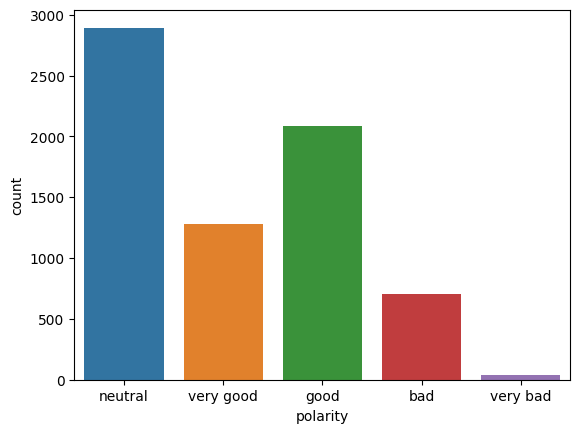

In [5]:
import seaborn as sns
sns.countplot(x=df["polarity"])


#### PreProssesing

In [6]:
def clean_html(s):
    return re.sub(re.compile('<.*?>'), '', s)

normalizer = Normalizer()    
def preprocessing(s):
  s = s.strip()
  
  s = clean_html(s)


  s = normalizer.normalize(s)

  extra_characters = re.compile("["
    u"\U0001F600-\U0001F64F"  
    u"\U0001F300-\U0001F5FF"  
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)

  s = extra_characters.sub(r'', s)
  s = re.sub("\s+", " ", s)         # trailing whitespace
  s = re.sub(r'(@.*?)[\s]', ' ', s) # @ mentions
  s = re.sub("#|\-", "", s)            # hashtags

  return s

In [7]:
df['text'] = df['text'].apply(preprocessing)

In [8]:
df.head(5)

,text,polarity
0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,neutral
1,پرینتری چند کاره از رده‌ی Entry Level یا سطح م...,neutral
2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ک...,neutral
3,به صورتی که توانایی کپی کردن، اسکن، فکس، پرینت...,neutral
4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,very good


## Part 1

In [9]:
# Split the data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["polarity"], test_size=0.2, random_state=10)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=10)

# Load the LaBSE tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")

# Tokenize the texts
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


In [10]:
# Convert labels to numerical values
label_mapping = {"very bad": 0, "bad": 1, "neutral": 2, "good": 3, "very good": 4}
train_labels = [label_mapping[label] for label in train_labels]
val_labels = [label_mapping[label] for label in val_labels]
test_labels = [label_mapping[label] for label in test_labels]



In [11]:
# Convert the data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings["input_ids"]),
    torch.tensor(val_encodings["attention_mask"]),
    torch.tensor(val_labels)
)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(test_labels)
)

In [9]:

# Define the model
# Define the model architecture
class SentimentClassifier(nn.Module):
    def __init__(self, num_labels):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("sentence-transformers/LaBSE")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [13]:


# Create the model
model = SentimentClassifier(num_labels=5)


# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)


# Set up the optimizer and the learning rate
optimizer = AdamW(model.parameters(), lr=1e-5)

# Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(501153, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [14]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=77c8a2c8085baabfda263dcad1cfc3faf7e37dbafa9ae78f65f2953663fa55e3
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 8.8 GB  |     Proc size: 4.1 GB
GPU RAM Free: 12368MB | Used: 2733MB | Util  18% | Total     15360MB


In [15]:
torch.cuda.empty_cache()

import gc
gc.collect()

torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1796 MiB |   1796 MiB |   1796 MiB |      0 B   |\n|       from large pool |   1796 MiB |   1796 MiB |   1796 MiB |      0 B   |\n|       from small pool |      0 MiB |      0 MiB |      0 MiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |   1796 MiB |   1796 MiB |   1796 MiB |      0 B   |\n|       from large pool |   1796 MiB |   1796 MiB |

In [16]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

num_epochs = 3
num_batches = len(train_loader)
log_interval = 20


def train(model, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    
    for i, batch in enumerate(dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs

        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)
        
        loss = nn.CrossEntropyLoss()(logits, labels)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        # Print accuracy and loss after every 20 batches
        if (i + 1) % 20 == 0:
            accuracy = correct_predictions / total_samples * 100
            avg_loss = running_loss / 20
            print(f"Batch: {i+1}, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")
            running_loss = 0.0
            total_samples = 0
            correct_predictions = 0


# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, optimizer, train_loader, device)



Epoch 1/3
Batch: 20, Accuracy: 37.50%, Loss: 1.4335
Batch: 40, Accuracy: 46.25%, Loss: 1.2913
Batch: 60, Accuracy: 44.38%, Loss: 1.2868
Batch: 80, Accuracy: 48.12%, Loss: 1.2027
Batch: 100, Accuracy: 53.12%, Loss: 1.0828
Batch: 120, Accuracy: 63.12%, Loss: 1.0120
Batch: 140, Accuracy: 63.12%, Loss: 0.9624
Batch: 160, Accuracy: 55.62%, Loss: 0.9499
Batch: 180, Accuracy: 63.12%, Loss: 0.8493
Batch: 200, Accuracy: 62.50%, Loss: 0.8336
Batch: 220, Accuracy: 65.62%, Loss: 0.8308
Batch: 240, Accuracy: 71.25%, Loss: 0.8675
Batch: 260, Accuracy: 68.12%, Loss: 0.8032
Batch: 280, Accuracy: 67.50%, Loss: 0.7584
Batch: 300, Accuracy: 73.75%, Loss: 0.6923
Batch: 320, Accuracy: 73.75%, Loss: 0.6802
Batch: 340, Accuracy: 71.88%, Loss: 0.6482
Batch: 360, Accuracy: 73.12%, Loss: 0.6442
Batch: 380, Accuracy: 71.88%, Loss: 0.6843
Batch: 400, Accuracy: 66.25%, Loss: 0.7859
Batch: 420, Accuracy: 70.62%, Loss: 0.6961
Batch: 440, Accuracy: 66.88%, Loss: 0.7741
Batch: 460, Accuracy: 66.25%, Loss: 0.7670
Batch

In [17]:
# Evaluation on the training set
model.eval()
train_predictions = []
train_true_labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs
        
        _, predicted_labels = torch.max(logits, 1)
        train_predictions.extend(predicted_labels.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())



In [18]:
# Evaluation on the training set
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs
        
        _, predicted_labels = torch.max(logits, 1)
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())



Accuracy: 0.7728571428571429
Precision: 0.770458287929349
Recall: 0.7728571428571429
F1-Score: 0.7713422812897957


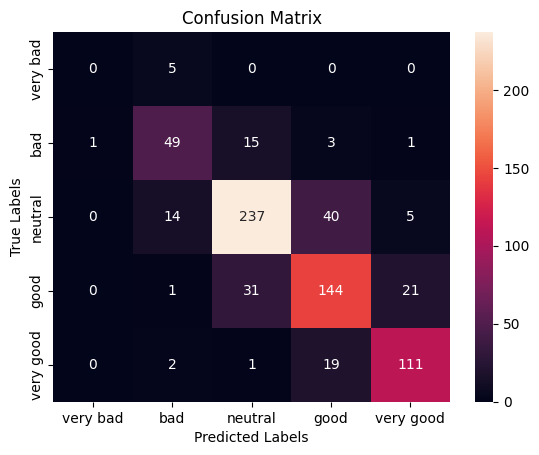

In [19]:
# Compute evaluation metrics
accuracy = accuracy_score(test_true_labels, test_predictions)
precision = precision_score(test_true_labels, test_predictions, average="weighted")
recall = recall_score(test_true_labels, test_predictions, average="weighted")
f1 = f1_score(test_true_labels, test_predictions, average="weighted")

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
total_samples = np.sum(cm)


import matplotlib.pyplot as plt 
classes = ['very bad', 'bad','neutral','good','very good']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True,  fmt='d', xticklabels=classes, yticklabels=classes, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

In [20]:
# Save the model's state dictionary
torch.save(model.state_dict(), "sentipers_model.pth")


## Part 2

#### Essential functions

In [40]:
def predict(testloader,model):
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    loop_val = tqdm(enumerate(testloader, 1),total=len(testloader),
                    desc="val",position=0,leave=True,)
    for batch, dl in loop_val:
      input_ids=dl['input_ids']
      token_type_ids=dl['token_type_ids']
      attention_mask= dl['attention_mask']
      labels=dl['target']

      input_ids=input_ids.to(device)
      token_type_ids=token_type_ids.to(device)
      attention_mask=attention_mask.to(device)
      labels=labels.to(device)

      labels_pred=model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids)
      _, predicted = torch.max(labels_pred, 1)

      # Append predicted labels and true labels to the lists
      all_predictions.extend(predicted.tolist())
      all_targets.extend(labels.tolist())
  return all_predictions,all_targets


class model_prt2(nn.Module):
    def __init__(self, model, num_classes):
        super(model_prt2, self).__init__()
        self.model=model
        self.model=self.model.to(device)
        self.softmax = nn.Softmax(dim=1)  
    
    def forward(self,input_ids,attention_mask,token_type_ids):
        o2= self.model(input_ids = input_ids,attention_mask=attention_mask)
        o2 = self.softmax(o2)

        return o2

class BertDataset(Dataset):
    def __init__(self, tokenizer,max_length,df):
        super(BertDataset, self).__init__()
        self.train_csv=df
        self.tokenizer=tokenizer
        self.labels=self.train_csv['label'].values
        self.max_length=max_length
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        text1 = self.train_csv.iloc[index,0]
        inputs = self.tokenizer.encode_plus(
            text1 ,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        input_ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        attention_mask = inputs["attention_mask"]
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.labels[index], dtype=torch.long)
            }


#### Read Snappfood Data and run the model

In [49]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### ReLoad the model from Part 1
num_labels = 5
model = SentimentClassifier(num_labels).to(device)

# Load the saved model's state dictionary
model.load_state_dict(torch.load("sentipers_model.pth"))

# Load the Snappfood dataset
df_snappfood = pd.read_csv("/content/drive/MyDrive/NLP/HW4/snapfood_testset.csv")

df_snappfood['label'] = df_snappfood['label'].replace({'SAD': 0, 'HAPPY': 1})

snapp_data = BertDataset(tokenizer, max_length=100,df=df_snappfood)
snapp_loader =DataLoader(dataset=snapp_data,batch_size=32)

# Add a softmax layer to the first model
model_Part2=model_prt2(model,2)

y_pred,y_test=predict(snapp_loader,model_Part2)

val: 100%|██████████| 219/219 [00:39<00:00,  5.56it/s]


In [50]:
from sklearn.metrics import classification_report
from itertools import product

y_pred = [0 if label < 2 else 1 for label in y_pred]
print("classification using zero shot learning on snappfood data report: ")
print(classification_report(y_pred, y_test))

classification using zero shot learning on snappfood data report: 
              precision    recall  f1-score   support

           0       0.68      0.82      0.75      2906
           1       0.85      0.73      0.79      4094

    accuracy                           0.77      7000
   macro avg       0.77      0.78      0.77      7000
weighted avg       0.78      0.77      0.77      7000



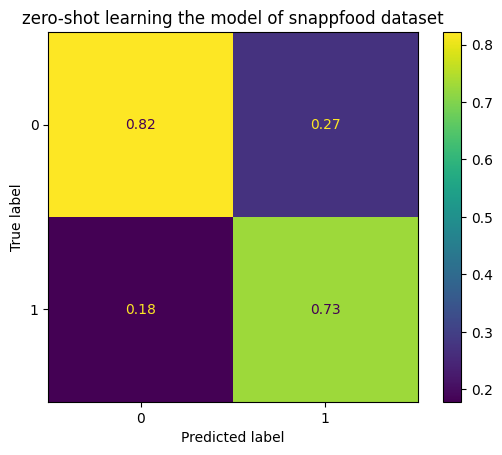

In [52]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred , normalize='pred' ))
disp.plot()
disp.ax_.set_title("zero-shot learning the model of snappfood dataset")
plt.show()